#**Deep semantic segmentation for building footprint extraction**

**Author:** [Fatemeh Chajaei](https://github.com/FatemehCh97)

# Load Packages

In [ ]:
!pip install keras_unet_collection

In [ ]:
import os
import glob
import numpy as np
import datetime
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report, f1_score, accuracy_score, precision_score, recall_score
from tqdm import notebook, tnrange
import matplotlib.pyplot as plt

In [ ]:
import keras
import keras_unet_collection
from keras_unet_collection import models, utils

In [ ]:
import tensorflow as tf
# from keras.models import *
# from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.losses import *
from keras_unet_collection.losses import iou_seg
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.models import load_model

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_dir = "/content/drive/My Drive/Miami Data/Train"
test_dir = "/content/drive/My Drive/Miami Data/Test"

List of train data names

In [ ]:
img_id = [] # list of names all images in the given path
for f in glob.glob(os.path.join(train_dir, "images", "*.tif")):
    img_id.append(os.path.split(f)[1].split(".")[0])
img_id.sort()

label_id = []
for f in glob.glob(os.path.join(train_dir, "labels", "*.tif")):
    label_id.append(os.path.split(f)[1].split(".")[0])
label_id.sort()

List of test data names

In [ ]:
test_img_id = []
for f in glob.glob(os.path.join(test_dir, "images", "*.tif")):
    test_img_id.append(os.path.split(f)[1].split(".")[0])
test_img_id.sort()

test_label_id = []
for f in glob.glob(os.path.join(test_dir, "labels", "*.tif")):
    test_label_id.append(os.path.split(f)[1].split(".")[0])
test_label_id.sort()

In [ ]:
im_width = 512
im_height = 512

Create NumPy zero arrays to store the data

In [ ]:
X = np.zeros((len(img_id), im_height, im_width, 1), dtype=np.float32)
# X = np.zeros((len(img_id), im_height, im_width, 3), dtype=np.float32) # DeepLabV3+
y = np.zeros((len(img_id), im_height, im_width, 1), dtype=np.float32)

X_test = np.zeros((len(test_img_id), im_height, im_width, 1), dtype=np.float32)
# X_test = np.zeros((len(test_img_id), im_height, im_width, 3), dtype=np.float32) # DeepLabV3+
y_test = np.zeros((len(test_img_id), im_height, im_width, 1), dtype=np.float32)

Train Data

In [ ]:
for n, id_ in notebook.tqdm(enumerate(img_id), total=len(img_id)):
    # Load images
    img = load_img(train_dir+"/images/"+id_+".tif", grayscale=True)
    # img = load_img(train_dir+"/images/"+id_+".tif", color_mode='rgb')  # Uncomment this line and use it if using model DeepLabV3+
    x_img = img_to_array(img)
    # Load masks
    mask = img_to_array(load_img(train_dir+"/labels/"+id_+".tif", grayscale=True))
    # Normalization
    X[n] = (x_img - x_img.min()) / (x_img.max() - x_img.min())
    # y[n] = (mask - mask.min()) / (mask.max() - mask.min())
    y[n] = mask

Test Data

In [ ]:
for n, id_ in notebook.tqdm(enumerate(test_img_id), total=len(test_img_id)):
    # Load images
    test_img = load_img(test_dir+"/images/"+id_+".tif", grayscale=True)
    # test_img = load_img(test_dir+"/images/"+id_+".tif", color_mode='rgb')  # DeepLabV3+
    test_x_img = img_to_array(test_img)
    # Load masks
    test_mask = img_to_array(load_img(test_dir+"/labels/"+id_+".tif", grayscale=True))
    # Normalization
    X_test[n] = (test_x_img - test_x_img.min()) / (test_x_img.max() - test_x_img.min())
    # y_test[n] = (test_mask - test_mask.min()) / (test_mask.max() - test_mask.min())
    y_test[n] = test_mask

Split validation data

In [ ]:
# Split data to train and validate
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=8, shuffle=True)

In [ ]:
print(np.shape(X_train))
print(np.shape(X_valid))
print(np.shape(X_test))

In [ ]:
total_training_sample = np.shape(X_train)[0]
batch_size = 8 # U-Net, Attention U-Net, DeepLabV3+
# batch_size = 4 # U-Net3+

# Plot Samples

Visualize images, their correspondig mask and prediction

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Images')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth Building footprint')

    ax[2].imshow(preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Building Footprint')

    ax[3].imshow(binary_preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    # if has_mask:
    #     ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Binary Predicted Building Footprint')

# Data Augmentation

In [ ]:
img_data_gen_args = dict(rotation_range=60,
                        width_shift_range=0.3,
                        height_shift_range=0.3,
                        shear_range=0.5,
                        horizontal_flip=True,
                        zoom_range=0.2,
                        fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=60,
                        width_shift_range=0.3,
                        height_shift_range=0.3,
                        shear_range=0.5,
                        horizontal_flip=True,
                        zoom_range=0.2,
                        fill_mode='reflect',
                        preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.

image_data_generator = ImageDataGenerator(**img_data_gen_args)


seed = 24

image_generator = image_data_generator.flow(X_train, batch_size=batch_size, seed=seed)
# valid_img_generator = image_data_generator.flow(X_valid, batch_size=batch_size)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

mask_generator = mask_data_generator.flow(y_train, batch_size=batch_size, seed=seed)
# valid_mask_generator = mask_data_generator.flow(y_valid, batch_size=batch_size)


def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [ ]:
train = my_image_mask_generator(image_generator, mask_generator)

# validation = my_image_mask_generator(valid_img_generator, valid_mask_generator)

# Deep Learning Models

## U-Net

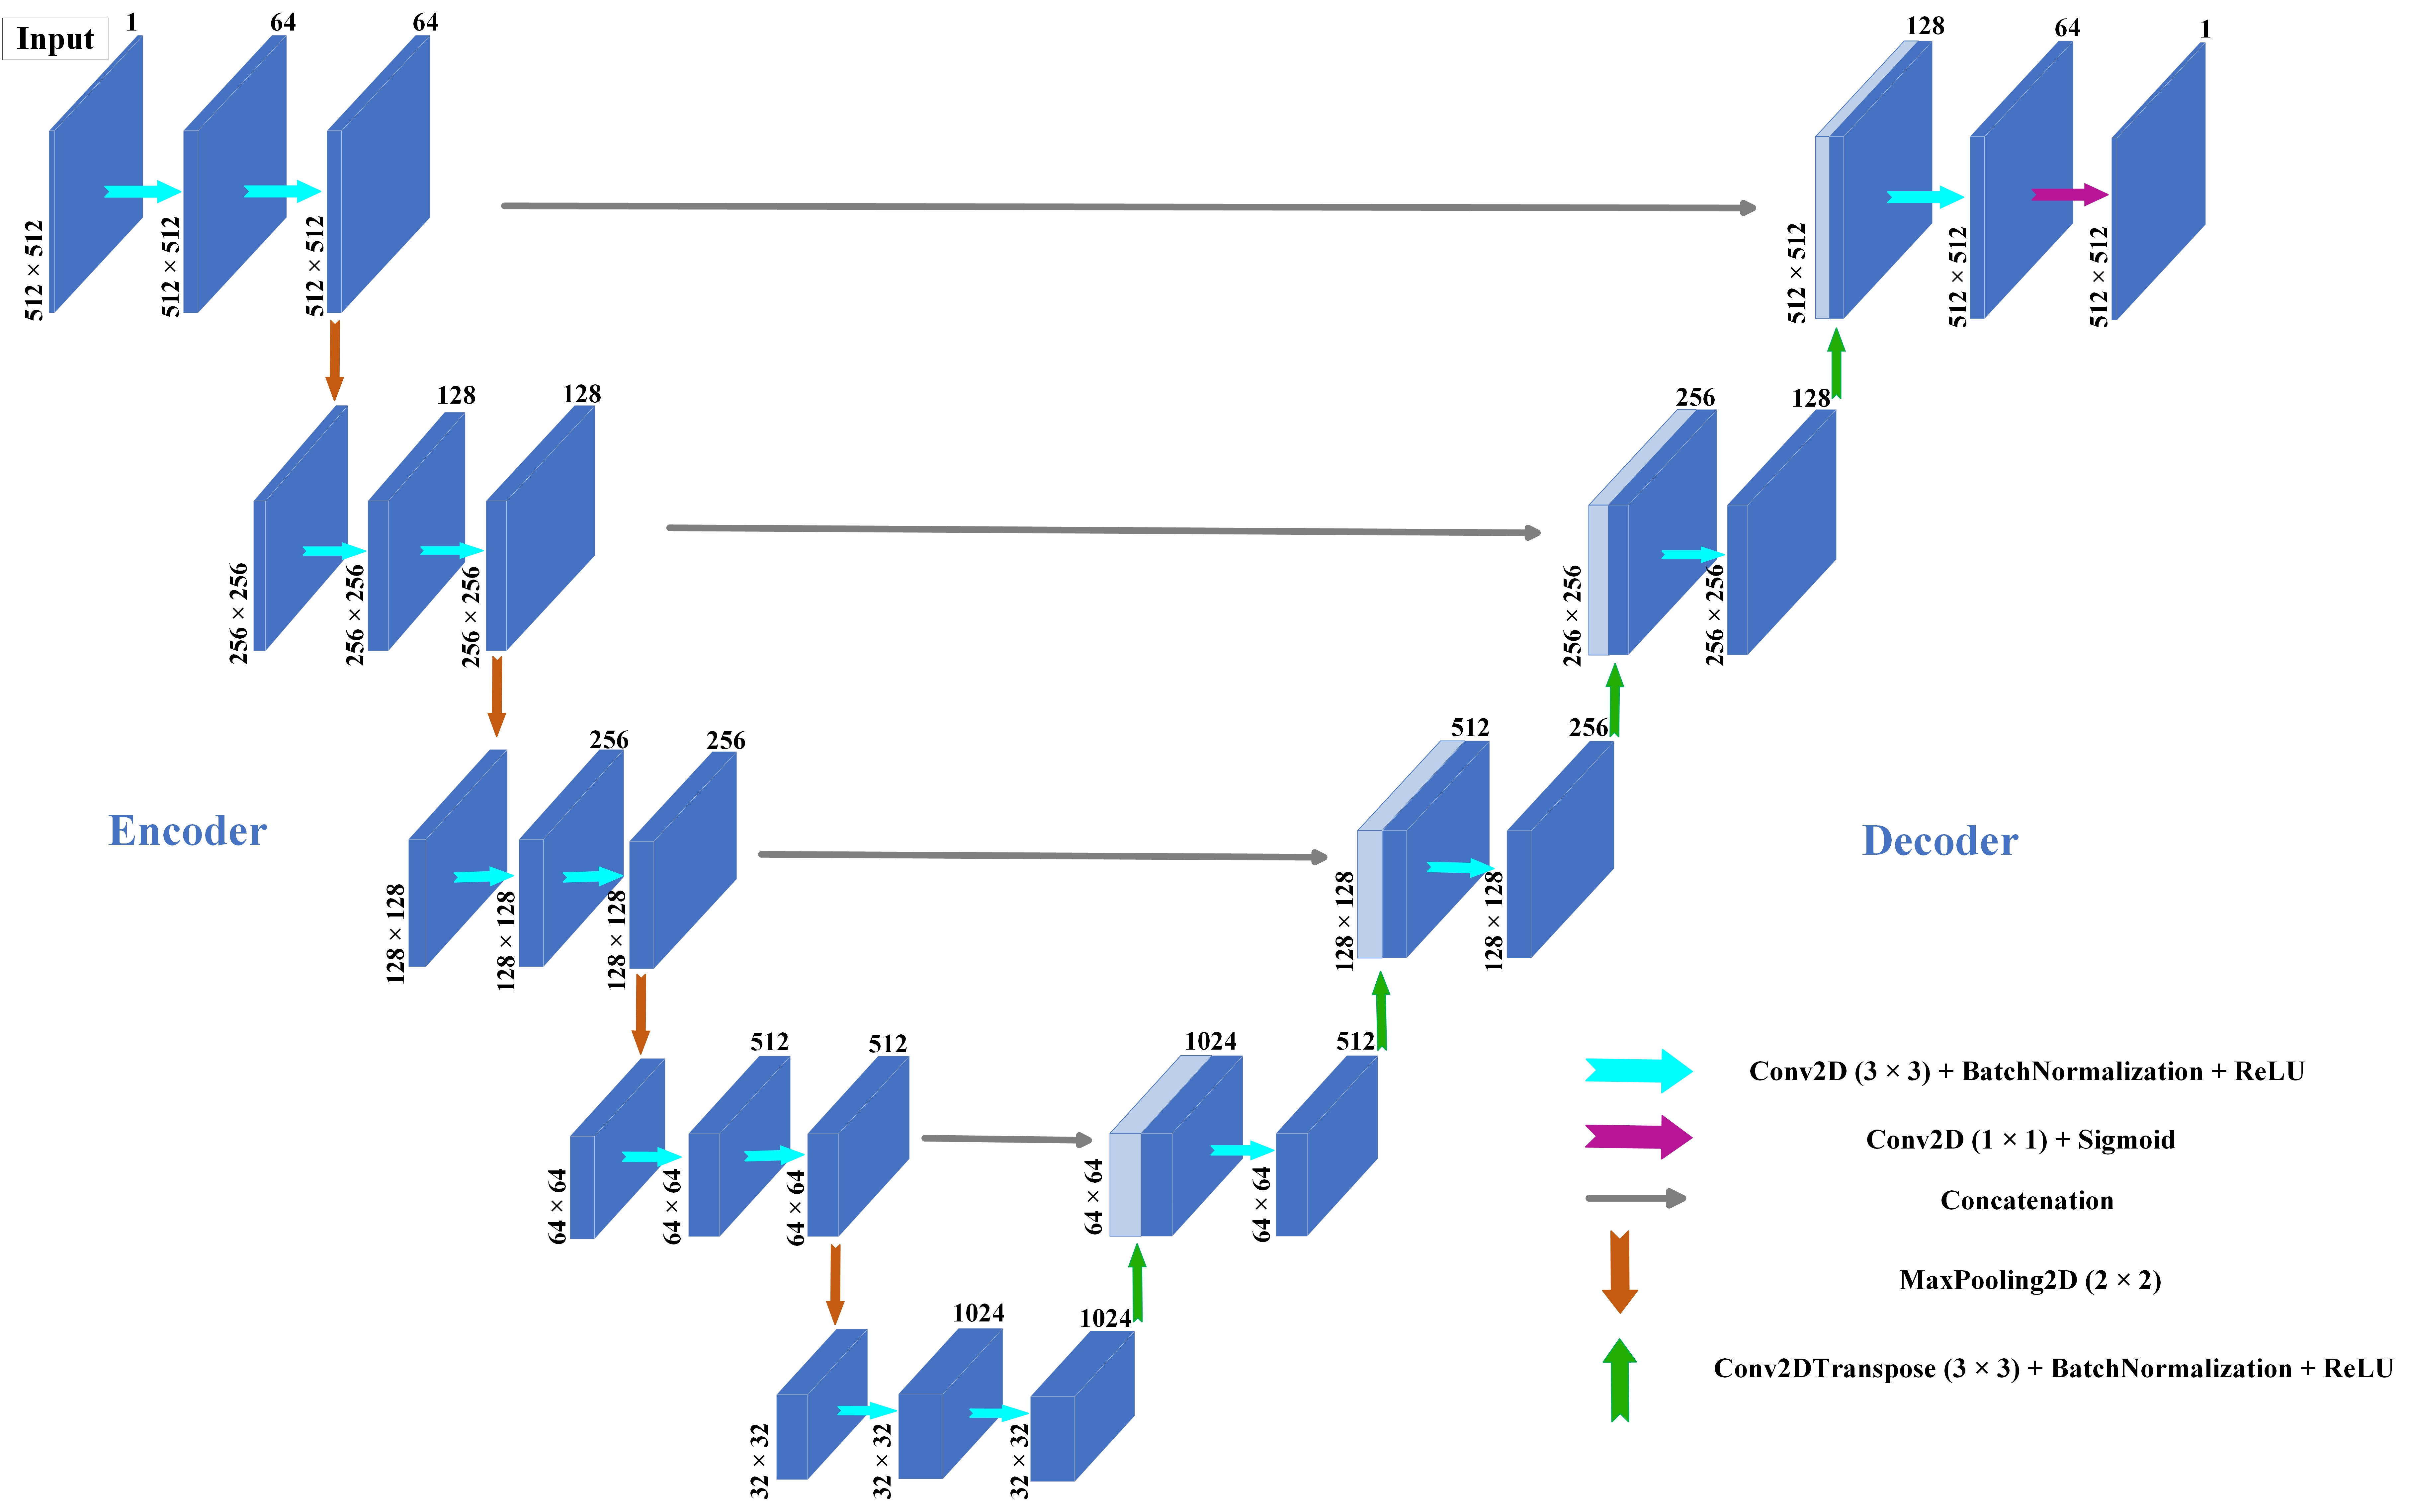

In [ ]:
help(models.unet_2d)

Help on function unet_2d in module keras_unet_collection._model_unet_2d:

unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    U-net with an optional ImageNet-trained bakcbone.
    
    unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
            activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
            backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    
    ----------
    Ronneberger, O., Fischer, P. and Brox, T., 2015, October. U-net: Convolutional networks for biomedical image segmentation. 
    In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.
    
    Input
    ----------
        input_s

In [ ]:
with tf.device('/CPU:0'):
    keras_unet_model = models.unet_2d((512, 512, 1), [64, 128, 256, 512, 1024], n_labels=1,
                                      stack_num_down=2, stack_num_up=1,
                                      activation='ReLU', output_activation='Sigmoid',
                                      batch_norm=True, pool='max', unpool=False , name='unet')
    keras_unet_model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8), loss='binary_crossentropy', metrics=['accuracy', 'mse'])
    logdir = os.path.join("/content/drive/My Drive/Model Output/U-Net", "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    print(logdir)
    callbacks = [tf.keras.callbacks.CSVLogger('/content/drive/My Drive/Model Output/U-Net/unet_model_1.csv', append=True, separator=';'),
             ModelCheckpoint(filepath='/content/drive/My Drive/Model Output/U-Net/unet_model_1.h5', monitor='val_accuracy',verbose=1, save_best_only=True),
             TensorBoard(logdir, histogram_freq=1)]

In [ ]:
keras.models.Model.summary(keras_unet_model)

In [ ]:
with tf.device('/GPU:0'):
    # keras_unet_model.fit(X_train, y_train, epochs=75, batch_size=8 , validation_data = (X_valid, y_valid), callbacks=callbacks) # Without data augmentation
    keras_unet_model.fit(train, steps_per_epoch=round(total_training_sample/batch_size), epochs=75, batch_size=batch_size , validation_data = (X_valid, y_valid), callbacks=callbacks)

### Result

In [ ]:
with tf.device('/CPU:0'):
    keras_unet_model = load_model('/content/drive/My Drive/Model Output/U-Net/unet_model_1.h5')

In [ ]:
# load the best model
keras_unet_model.load_weights('/content/drive/My Drive/Model Output/U-Net/unet_model_1.h5')
# keras_unet_model.get_weights()

In [ ]:
# Evaluation (this must be equals to the best log_loss)
keras_unet_model.evaluate(X_train, y_train, verbose=1, batch_size=8)
keras_unet_model.evaluate(X_valid, y_valid, verbose=1, batch_size=8)
keras_unet_model.evaluate(X_test, y_test, verbose=1, batch_size=8)

In [ ]:
# Predict on train, val and test
preds_train_unet = keras_unet_model.predict(X_train, batch_size=8, verbose=1)
preds_val_unet = keras_unet_model.predict(X_valid, batch_size=8, verbose=1)
preds_test_unet = keras_unet_model.predict(X_test, batch_size=8, verbose=1)

In [ ]:
# Binary predictions
preds_train_t_u = (preds_train_unet > 0.5).astype(np.uint8)
preds_val_t_u = (preds_val_unet > 0.5).astype(np.uint8)
preds_test_t_u = (preds_test_unet > 0.5).astype(np.uint8)

In [ ]:
# plot random sample
plot_sample(X_test, y_test, preds_test_unet, preds_test_t_u, ix=None)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=logdir

#### Evaluation Metrics

In [ ]:
intersection = np.logical_and(y_test, preds_test_t_u)
union = np.logical_or(y_test, preds_test_t_u)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
y_true = y_test.flatten()
y_pred_unet = preds_test_t_u.flatten()

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, y_pred_unet)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_unet)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_unet)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred_unet)
print('F1 score: %f' % f1)

## Attention U-Net

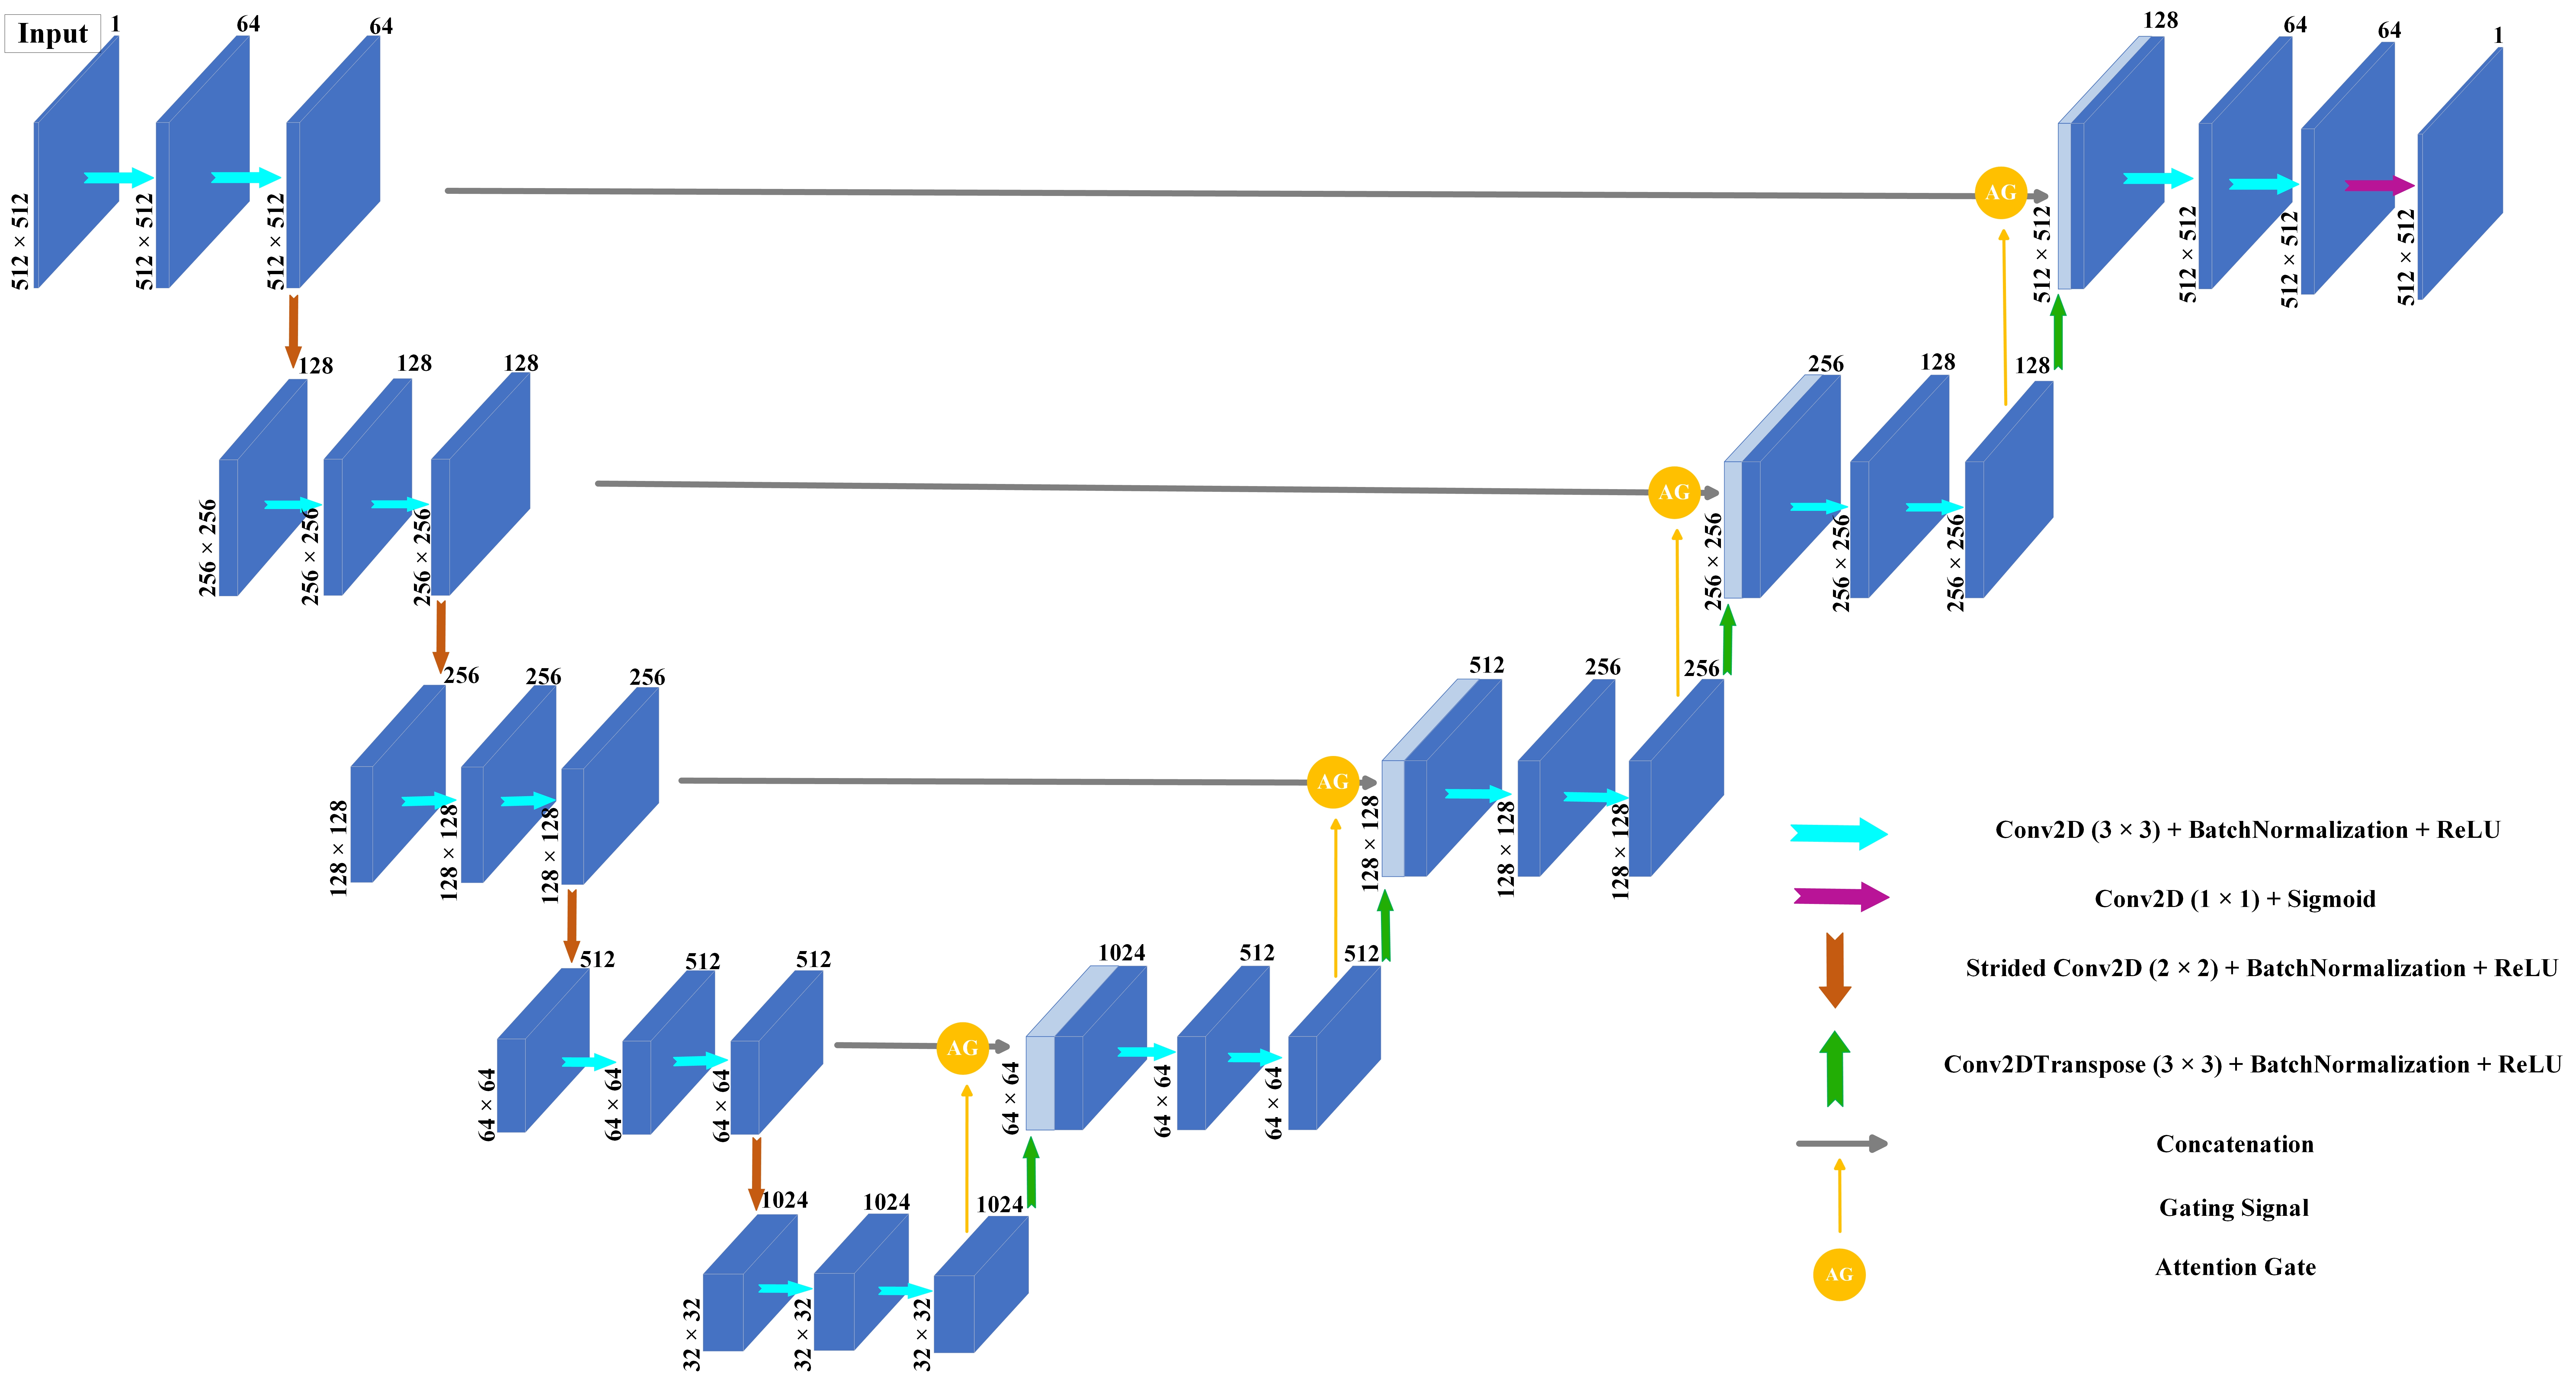

In [ ]:
help(models.att_unet_2d)

In [ ]:
with tf.device('/CPU:0'):
    keras_attention_model = models.att_unet_2d((512, 512, 1), [64, 128, 256, 512, 1024], n_labels=1,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU', atten_activation='ReLU', attention='add', output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False, name='attunet')
    keras_attention_model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8), loss='binary_crossentropy', metrics=['accuracy', 'mse'])
    logdir = os.path.join("/content/drive/My Drive/Model Output/Attention U-Net", "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    print(logdir)
    callbacks = [tf.keras.callbacks.CSVLogger("/content/drive/My Drive/Model Output/Attention U-Net/attention_model_1.csv", append=True, separator=';'),
             ModelCheckpoint(filepath="/content/drive/My Drive/Model Output/Attention U-Net/attention_model_1.h5", monitor='val_accuracy',verbose=1, save_best_only=True),
             TensorBoard(logdir, histogram_freq=1),
#              ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
                ]

In [ ]:
keras.models.Model.summary(keras_attention_model)

In [ ]:
with tf.device('/GPU:0'):
    # keras_attention_model.fit(X_train, y_train, epochs=75, batch_size=8 , validation_data = (X_valid, y_valid), callbacks=callbacks)
    keras_attention_model.fit(train, steps_per_epoch=round(total_training_sample/batch_size), epochs=75, batch_size=batch_size , validation_data = (X_valid, y_valid), callbacks=callbacks)

### Result

In [ ]:
with tf.device('/CPU:0'):
    keras_attention_model = load_model("/content/drive/My Drive/Model Output/Attention U-Net/attention_model_1.h5")

In [ ]:
# load the best model
keras_attention_model.load_weights("/content/drive/My Drive/Model Output/Attention U-Net/attention_model_1.h5")
# keras_attention_model.get_weights()

In [ ]:
# Evaluate on validation set
keras_attention_model.evaluate(X_train, y_train, verbose=1, batch_size=8)
keras_attention_model.evaluate(X_valid, y_valid, verbose=1, batch_size=8)
keras_attention_model.evaluate(X_test, y_test, verbose=1, batch_size=8)

In [ ]:
# Predict on train, val and test
preds_train_attention = keras_attention_model.predict(X_train, batch_size=2, verbose=1)
preds_val_attention = keras_attention_model.predict(X_valid, batch_size=2, verbose=1)
preds_test_attention = keras_attention_model.predict(X_test, batch_size=2, verbose=1)

In [ ]:
# Binary predictions
preds_train_t_att = (preds_train_attention > 0.5).astype(np.uint8)
preds_val_t_att = (preds_val_attention > 0.5).astype(np.uint8)
preds_test_t_att = (preds_test_attention > 0.5).astype(np.uint8)

In [ ]:
# Plot random sample
plot_sample(X_test, y_test, preds_test_attention, preds_test_t_att, ix=None)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=logdir

#### Evaluation Metrics

In [ ]:
intersection = np.logical_and(y_test, preds_test_t_att)
union = np.logical_or(y_test, preds_test_t_att)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
y_true = y_test.flatten()
y_pred_att = preds_test_t_att.flatten()

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, y_pred_att)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_att)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_att)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred_att)
print('F1 score: %f' % f1)

## U-Net3+

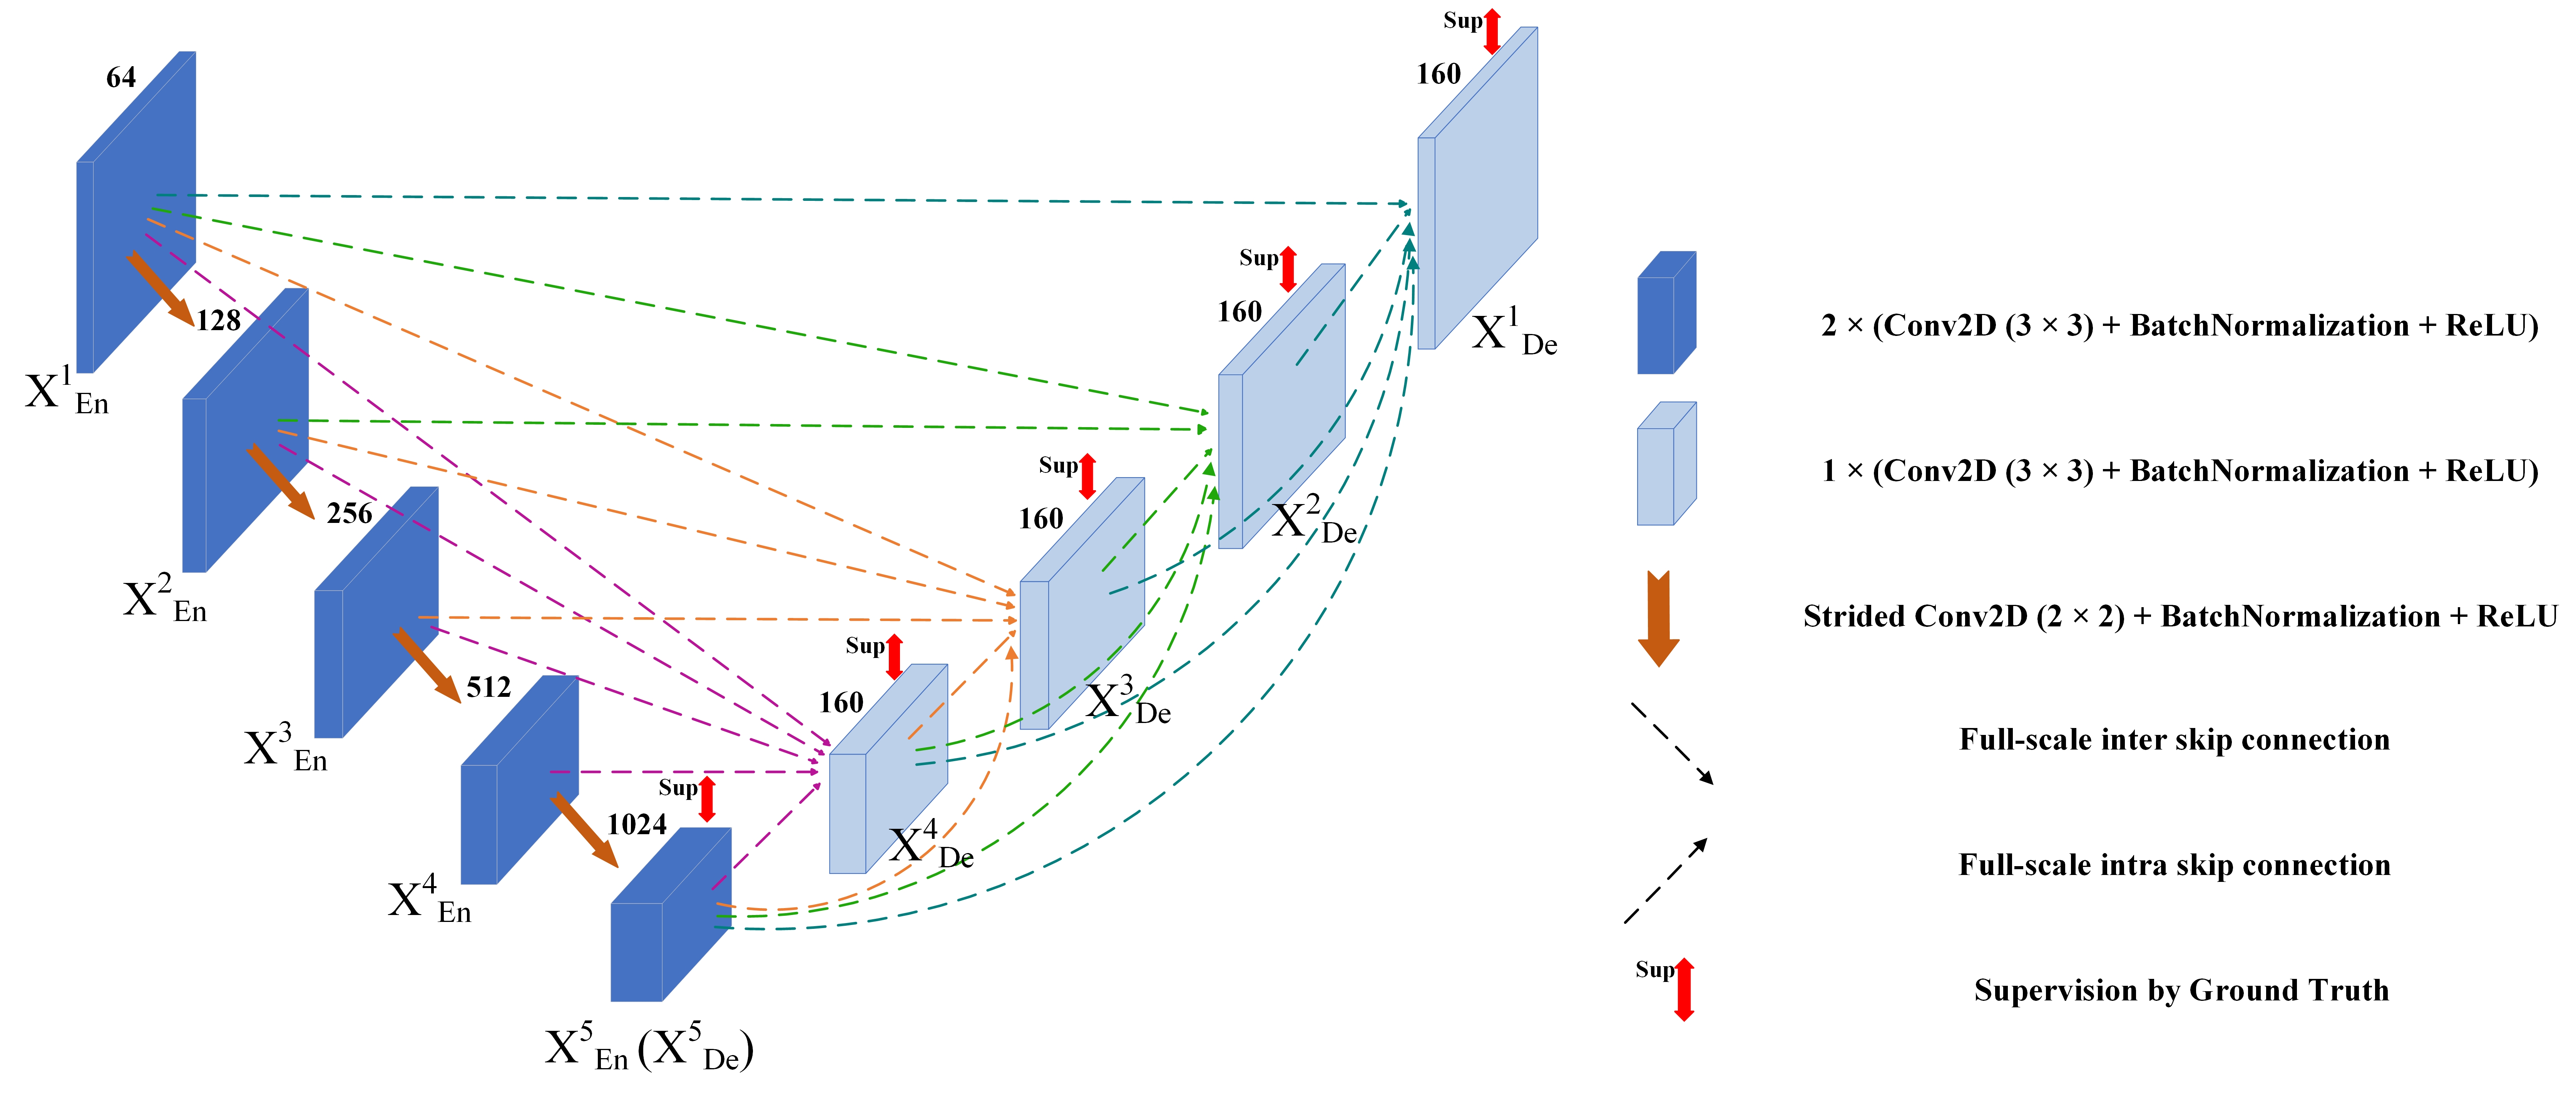

In [ ]:
help(models.unet_3plus_2d)

In [ ]:
name = 'unet3plus'
activation = 'ReLU'

filter_num_down = [64, 128, 256, 512, 1024]
filter_num_skip = [32, 32, 32, 32]
filter_num_aggregate = 160

stack_num_down = 2
stack_num_up = 1
n_labels = 1

input_tensor = keras.layers.Input((512, 512, 1))
# base architecture
X_decoder = base.unet_3plus_2d_base(
    input_tensor, filter_num_down, filter_num_skip, filter_num_aggregate,
    stack_num_down=stack_num_down, stack_num_up=stack_num_up, activation=activation,
    batch_norm=True, pool=False, unpool=False, backbone=None, name=name)


In [ ]:
X_decoder

Deep Supervision

In [ ]:
# allocating deep supervision tensors
OUT_stack = []
# reverse indexing `X_decoder`, so smaller tensors have larger list indices
X_decoder = X_decoder[::-1]

# deep supervision outputs
for i in range(1, len(X_decoder)):
    # 3-by-3 conv2d --> upsampling --> sigmoid output activation
    pool_size = 2**(i)
    X = Conv2D(n_labels, 3, padding='same', name='{}_output_conv1_{}'.format(name, i-1))(X_decoder[i])

    X = UpSampling2D((pool_size, pool_size), interpolation='bilinear',
                     name='{}_output_sup{}'.format(name, i-1))(X)

    X = Activation('sigmoid', name='{}_output_sup{}_activation'.format(name, i-1))(X)
    # collecting deep supervision tensors
    OUT_stack.append(X)

# the final output (without extra upsampling)
# 3-by-3 conv2d --> sigmoid output activation
X = Conv2D(n_labels, 3, padding='same', name='{}_output_final'.format(name))(X_decoder[0])
X = Activation('sigmoid', name='{}_output_final_activation'.format(name))(X)
# collecting final output tensors
OUT_stack.append(X)

In [ ]:
OUT_stack

Classification-guided Module (CGM)

In [ ]:
# Classification-guided Module (CGM)
# ---------------------------------------- #
# dropout --> 1-by-1 conv2d --> global-maxpooling --> sigmoid
X_CGM = X_decoder[-1]
X_CGM = Dropout(rate=0.1)(X_CGM)
X_CGM = Conv2D(filter_num_skip[-1], 1, padding='same')(X_CGM)
X_CGM = GlobalMaxPooling2D()(X_CGM)
X_CGM = Activation('sigmoid')(X_CGM)

CGM_mask = max(X_CGM, axis=-1) # <----- This value could be trained with "none-organ image"

for i in range(len(OUT_stack)):
    if i < len(OUT_stack)-1:
        # deep-supervision
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_sup{}_CGM'.format(name, i))
    else:
        # final output
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_final_CGM'.format(name))


In [ ]:
OUT_stack

Compiling the segmentation model

In [ ]:
# executing all the above cells in one time to avoid dupilcated tensor names.
with tf.device('/CPU:0'):
    unet3plus = keras.models.Model([input_tensor,], OUT_stack)

Hybrid loss

In [ ]:
from keras_unet_collection import losses

def hybrid_loss(y_true, y_pred):

    loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
    loss_iou = losses.iou_seg(y_true, y_pred)

    # (x)
    #loss_ssim = losses.ms_ssim(y_true, y_pred, max_val=1.0, filter_size=4)

    return loss_focal+loss_iou #+loss_ssim

In [ ]:
with tf.device('/CPU:0'):
        unet3plus.compile(loss=[hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss],
                          loss_weights=[0.25, 0.25, 0.25, 0.25, 1.0],
                          optimizer=keras.optimizers.Adam(learning_rate=1e-4))
        logdir = os.path.join("/content/drive/My Drive/Model Output/U-Net3+", "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        print(logdir)
        callbacks = [tf.keras.callbacks.CSVLogger("/content/drive/My Drive/Model Output/U-Net3+/unet3p_model_1.csv", append=True, separator=';'),
                    ModelCheckpoint(filepath="/content/drive/My Drive/Model Output/U-Net3+/unet3p_model_1.h5", monitor='unet3plus_output_final_CGM_loss', mode='min',verbose=1, save_best_only=True),
                    TensorBoard(logdir, histogram_freq=1)]

**NOTE**

[Batch_size = 4](#scrollTo=aWv-yvPpdp6C&line=2&uniqifier=1)

In [ ]:
history = unet3plus.fit(train, steps_per_epoch=round(total_training_sample/batch_size), epochs=75, batch_size=batch_size , validation_data = (X_valid, y_valid), callbacks=callbacks)

### Results

In [ ]:
with tf.device('/CPU:0'):
    unet3plus = load_model("/content/drive/My Drive/Model Output/U-Net3+/unet3p_model_1.h5", compile=False)

In [ ]:
# Evaluate on validation set
unet3plus.evaluate(X_train, y_train, verbose=1, batch_size=4)
unet3plus.evaluate(X_valid, y_valid, verbose=1, batch_size=4)
unet3plus.evaluate(X_test, y_test, verbose=1, batch_size=4)

In [ ]:
# Predict on train, val and test
preds_train_unet3p = unet3plus.predict(X_train, batch_size=4, verbose=1)
preds_val_unet3p = unet3plus.predict(X_valid, batch_size=4, verbose=1)
preds_test_unet3p = unet3plus.predict(X_test, batch_size=2, verbose=1)

In [ ]:
preds_train_unet3p_1 = preds_train_unet3p[-1]
preds_val_unet3p_1 = preds_val_unet3p[-1]
preds_test_unet3p_1 = preds_test_unet3p[-1]

In [ ]:
# Binary predictions
preds_train_t_u3 = (preds_train_unet3p_1 > 0.5).astype(np.uint8)
preds_val_t_u3 = (preds_val_unet3p_1 > 0.5).astype(np.uint8)
preds_test_t_u3 = (preds_test_unet3p_1 > 0.5).astype(np.uint8)

In [ ]:
# Plot random sample
plot_sample(X_test, y_test, preds_test_unet3p_1, preds_test_t_u3, ix=None)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=logdir

#### Evaluation Metrics

In [ ]:
intersection = np.logical_and(y_test, preds_test_t_u3)
union = np.logical_or(y_test, preds_test_t_u3)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
y_true = y_test.flatten()
y_pred_u3 = preds_test_t_u3.flatten()

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, y_pred_u3)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_u3)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_u3)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred_u3)
print('F1 score: %f' % f1)

## DeepLabV3+

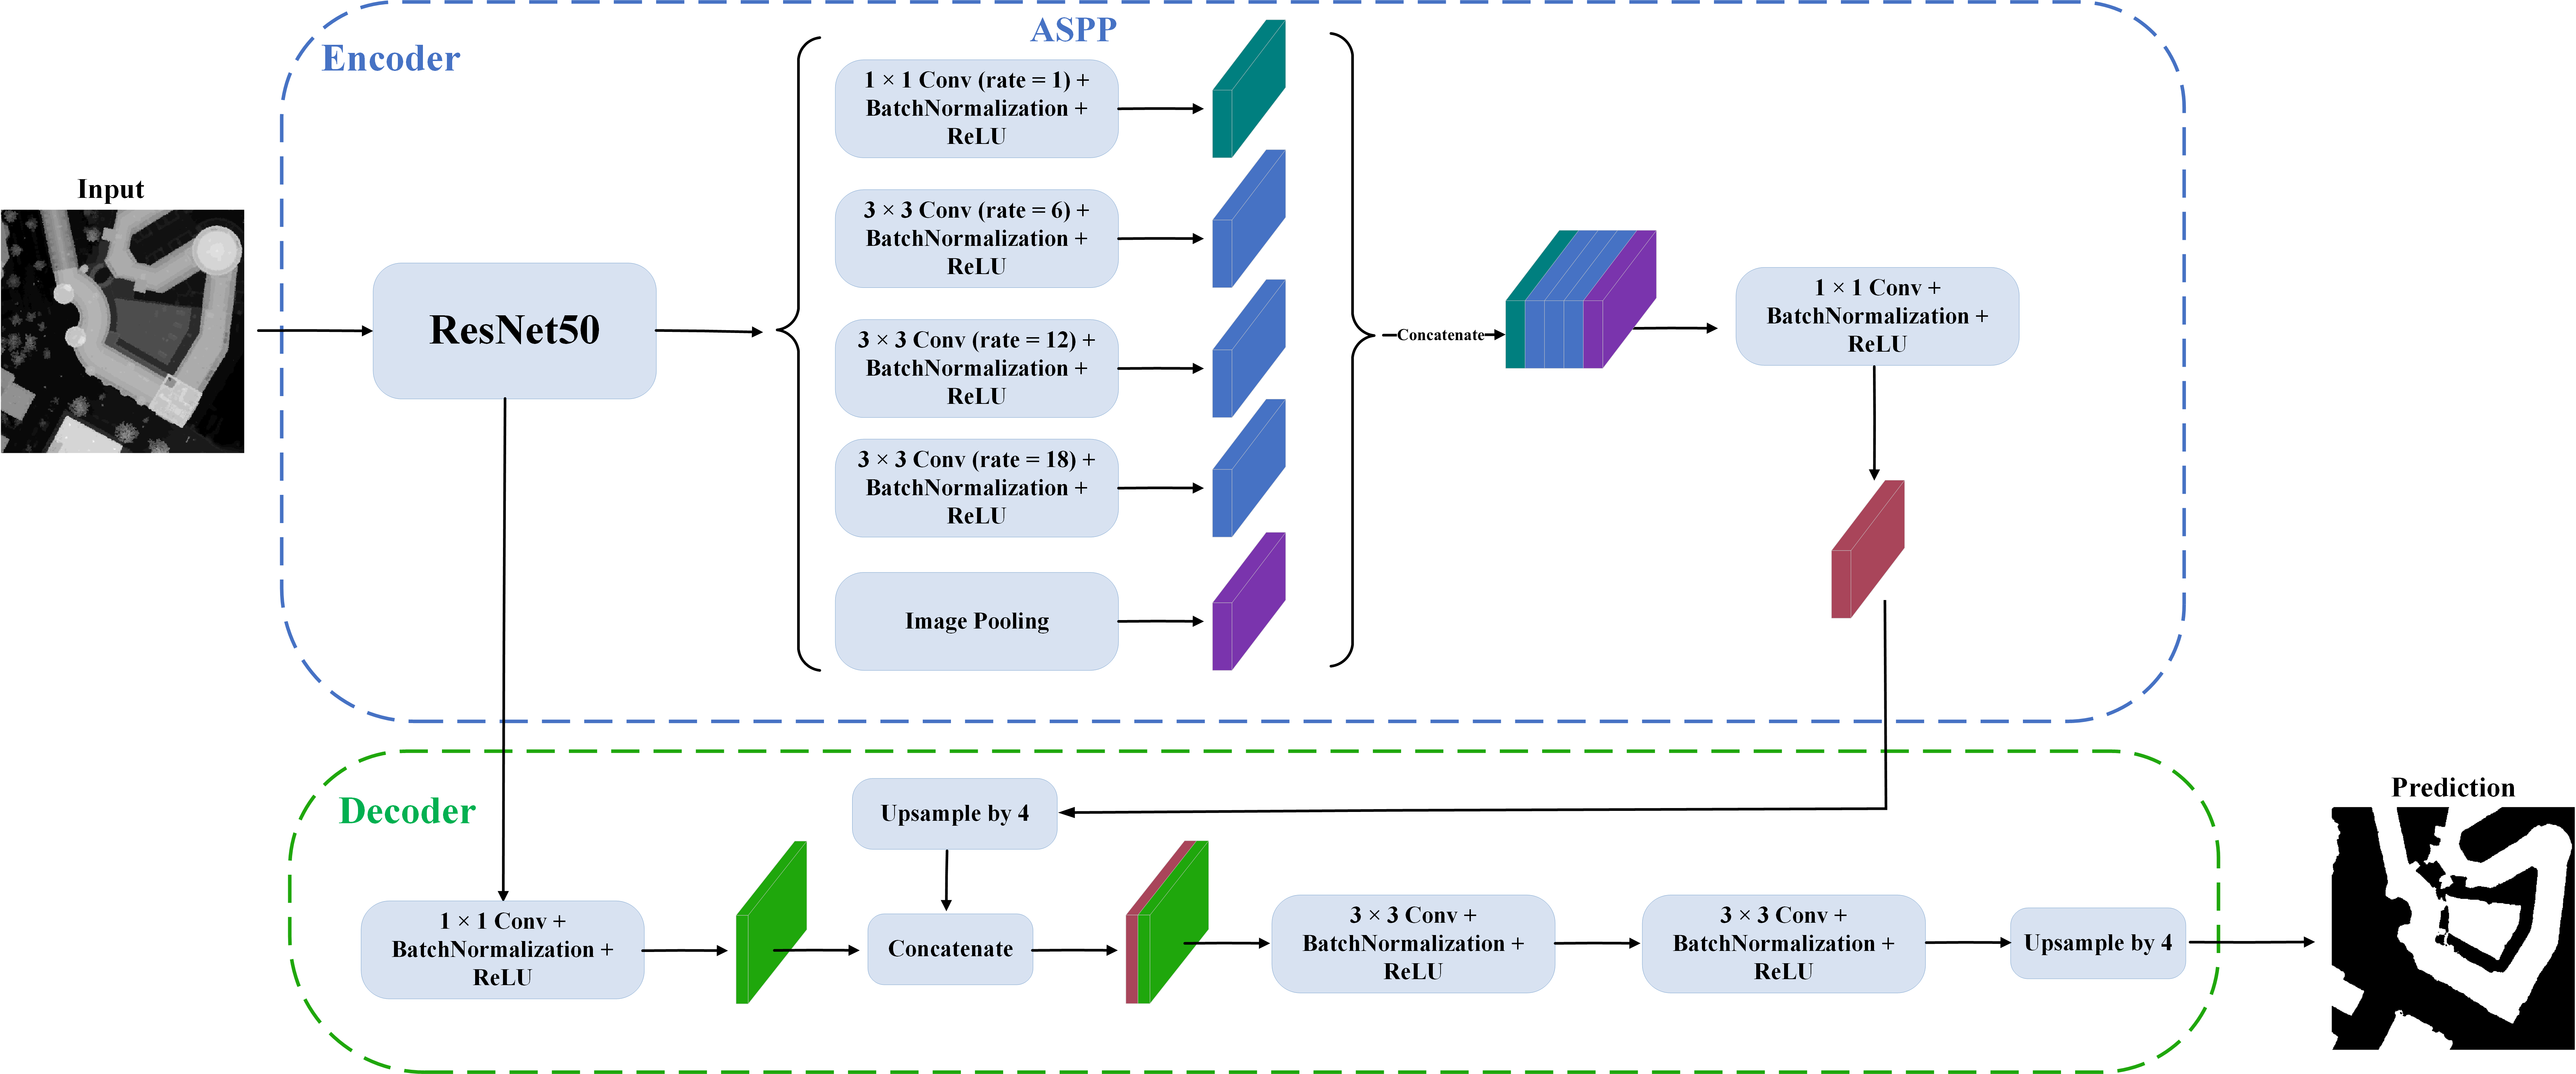

**NOTE**

[use 'rgb' color mode in load_img](#scrollTo=e1h4CbbePmZe&line=4&uniqifier=1)

In [ ]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
with tf.device('/CPU:0'):
    deeplab_model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

In [ ]:
deeplab_model.summary()

In [ ]:
with tf.device('/CPU:0'):
        # loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(optimizer=Adam(learning_rate = 1e-4, epsilon=1e-2), loss='binary_crossentropy', metrics=['accuracy', 'mse'])
        logdir = os.path.join("/content/drive/My Drive/Model Output/DeepLabV3+", "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        print(logdir)
        callbacks = [tf.keras.callbacks.CSVLogger("/content/drive/My Drive/Model Output/DeepLabV3+/deeplab_model_1.csv", append=True, separator=';'),
                ModelCheckpoint(filepath="/content/drive/My Drive/Model Output/DeepLabV3+/deeplab_model_1.h5", monitor='val_accuracy',verbose=1, save_best_only=True),
                TensorBoard(logdir, histogram_freq=1)]


In [ ]:
histor = deeplab_model.fit(train, steps_per_epoch=round(total_training_sample/batch_size), validation_data=(X_valid, y_valid), epochs=75, batch_size=8, callbacks=callbacks)

### Results

In [ ]:
with tf.device('/CPU:0'):
    deeplab_model = load_model("/content/drive/My Drive/Model Output/DeepLabV3+/deeplab_model_1.h5")

In [ ]:
# Evaluate on validation set
deeplab_model.evaluate(X_train, y_train, verbose=1, batch_size=8)
deeplab_model.evaluate(X_valid, y_valid, verbose=1, batch_size=8)
deeplab_model.evaluate(X_test, y_test, verbose=1, batch_size=8)

In [ ]:
# Predict on train, val and test
preds_train_deeplab = deeplab_model.predict(X_train, batch_size=8, verbose=1)
preds_val_deeplab = deeplab_model.predict(X_valid, batch_size=8, verbose=1)
preds_test_deeplab = deeplab_model.predict(X_test, batch_size=8, verbose=1)

In [ ]:
# Binary predictions
preds_train_t_dl = (preds_train_deeplab > 0.5).astype(np.uint8)
preds_val_t_dl = (preds_val_deeplab > 0.5).astype(np.uint8)
preds_test_t_dl = (preds_test_deeplab > 0.5).astype(np.uint8)

In [ ]:
# Plot random sample
plot_sample(X_test, y_test, preds_test_deeplab, preds_test_t_dl, ix=None)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=logdir

#### Evaluation Metrics

In [ ]:
intersection = np.logical_and(y_test, preds_test_t_dl)
union = np.logical_or(y_test, preds_test_t_dl)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
y_true = y_test.flatten()
y_pred_dl = preds_test_t_dl.flatten()

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, y_pred_dl)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_dl)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_dl)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred_dl)
print('F1 score: %f' % f1)